In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as ss

import sage.xai.atlas_overlap as ao
import sage.xai.atlas as A
import meta_brain.router as C


skip_keys = [
    "CC_Posterior",
    "CC_Mid_Posterior",
    "CC_Central",
    "CC_Mid_Anterior",
    "CC_Anterior"
]


def sort_xai_dict(dct: dict):
    dct = {k: v for k, v in dct.items() if k not in skip_keys}
    dct = sorted(dct.items(), key=lambda x: x[0])
    dct = [v[1] for v in dct]
    return dct


def run_stats(a, b, stat_only: bool = True) -> dict:
    _dct = defaultdict(dict)
    for method in ["wilcoxon", "spearmanr", "kendalltau", "somersd", "kruskal"]:
        stats = getattr(ss, method)(a, b)
        print(f"{method}: STAT {stats.statistic:.4f} | p-val: {stats.pvalue:.4f}")
        if stat_only:
            _dct["stats"][method] = stats.statistic
            _dct["pval"][method] = stats.pvalue
        else:
            _dct[method] = stats
    return _dct

In [2]:
# Load FastSurfer SpearmanR stats and ATLAS

with open(C.FS_VOX, mode="r") as f:
    vox_spear = json.load(f)
vox_spear = {k: v for k, v in vox_spear.items() if k not in skip_keys} # Skip keys with nan
vox_spear = sorted(vox_spear.items(), key=lambda x: x[0]) # Sort by key name
vox_spear = [v[1][0] for v in vox_spear] # Leave spearman stats only

with open(C.FS_INT, mode="r") as f:
    int_spear = json.load(f)
int_spear = {k: v for k, v in int_spear.items() if k not in skip_keys} # Skip keys with nan
int_spear = sorted(int_spear.items(), key=lambda x: x[0]) # Sort by key name
int_spear = [v[1][0] for v in int_spear] # Leave spearman stats only

with (C.VBM_12cont / "vbm_dict.json").open(mode="r") as f:
    cont_12_dict = json.load(f)
    _cont_12_dict = sort_xai_dict(dct=cont_12_dict)
    
with (C.VBM_21cont / "vbm_dict.json").open(mode="r") as f:
    cont_21_dict = json.load(f)
    _cont_21_dict = sort_xai_dict(dct=cont_21_dict)

atlas = A.get_atlas(atlas_name="dkt", return_mni=False)

/home/1pha/codespace/brain-age-prediction/sage/xai/utils.py:172: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
INFO:/home/1pha/codespace/brain-age-prediction/sage/xai/atlas_overlap.py:Overlaps with absolute values
Aggregating values across ROIs:  32%|███▏      | 32/100 [00:01<00:03, 20.03it/s]/home/1pha/codespace/brain-age-prediction/sage/xai/atlas_overlap.py:126: RuntimeWarning: invalid value encountered in scalar divide
  xai_dict[label] = roi_val / num_nonzero
Spread values to Brain ROI ...: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]
/home/1pha/.conda/envs/age/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/1pha/codespace/brain-age-prediction/sage/xai/utils.py:172: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
INFO:/home/1pha/codespace/brain-age-prediction/sage/xai/atlas_o

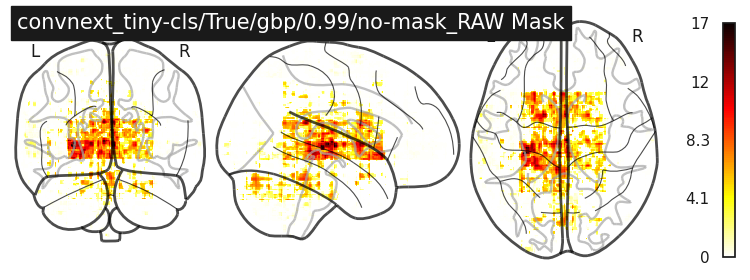

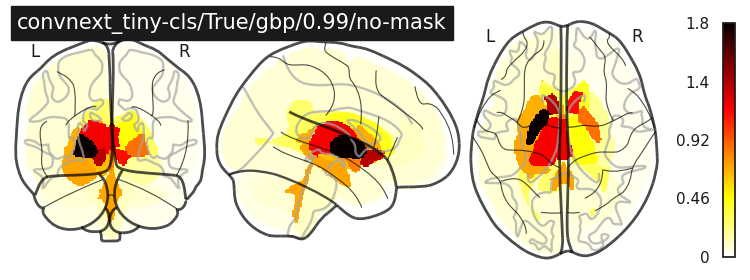

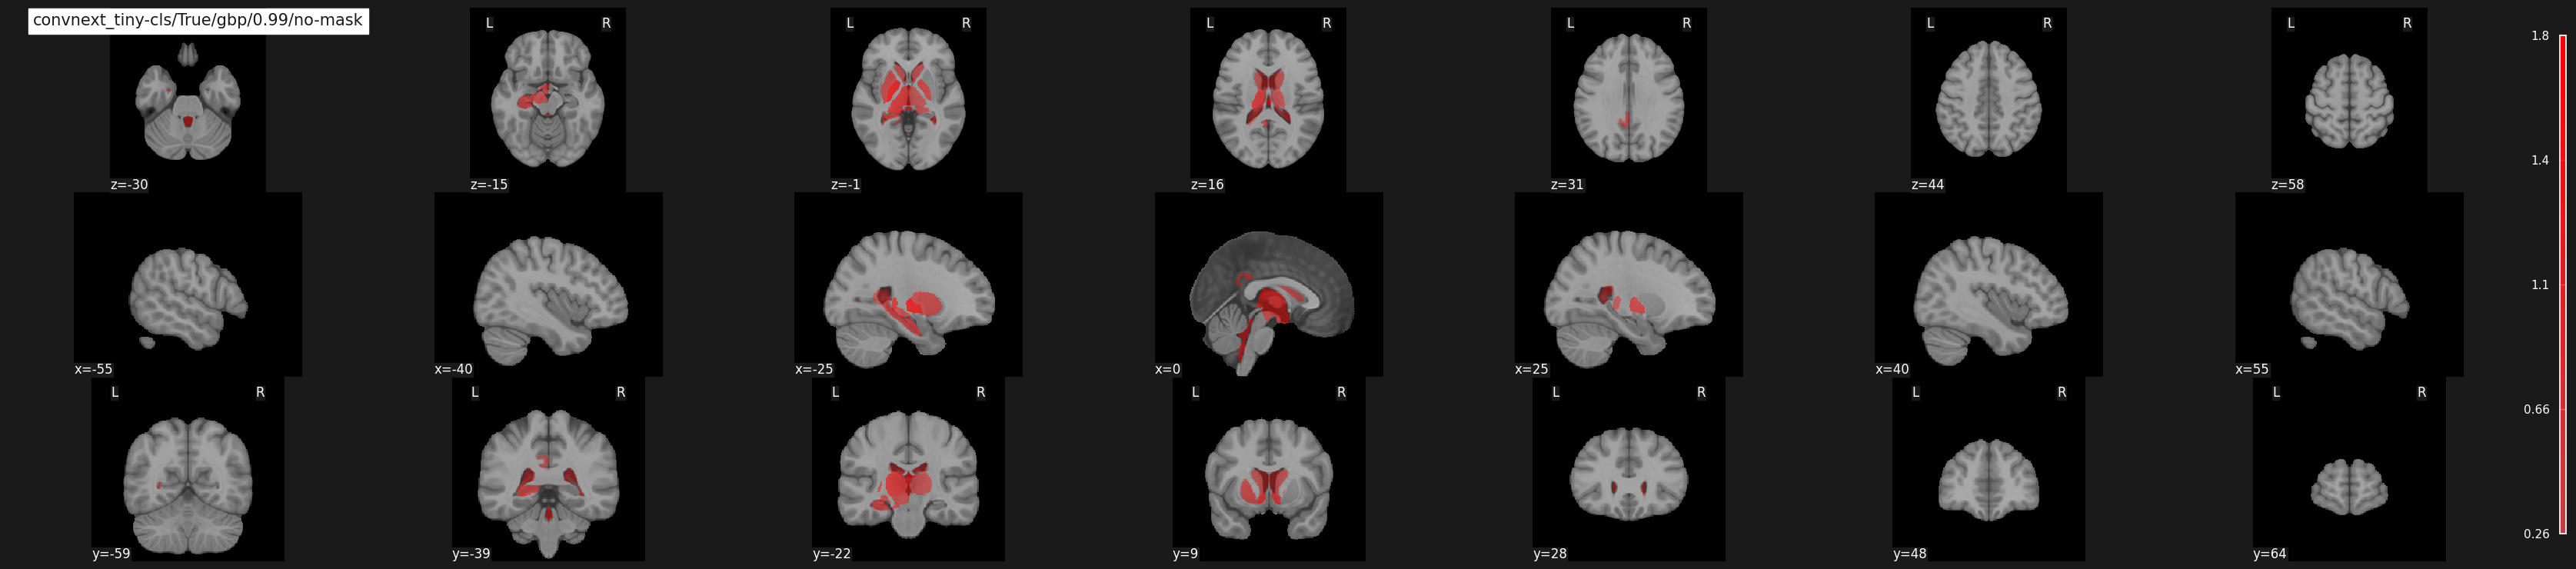

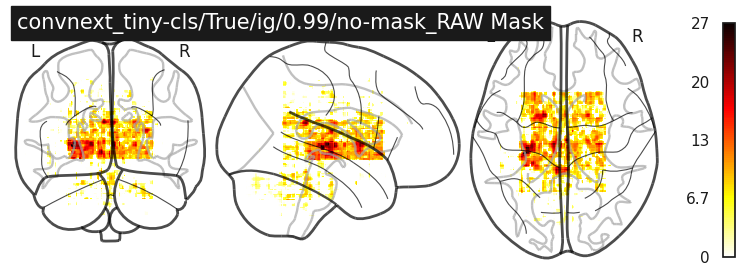

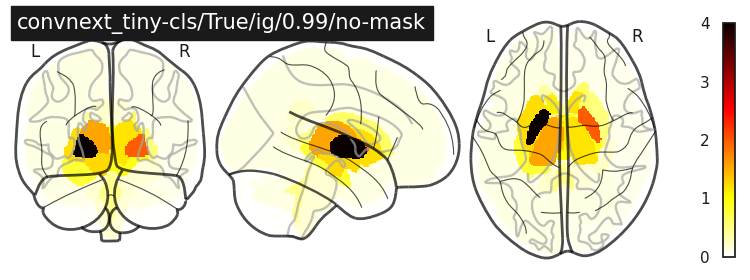

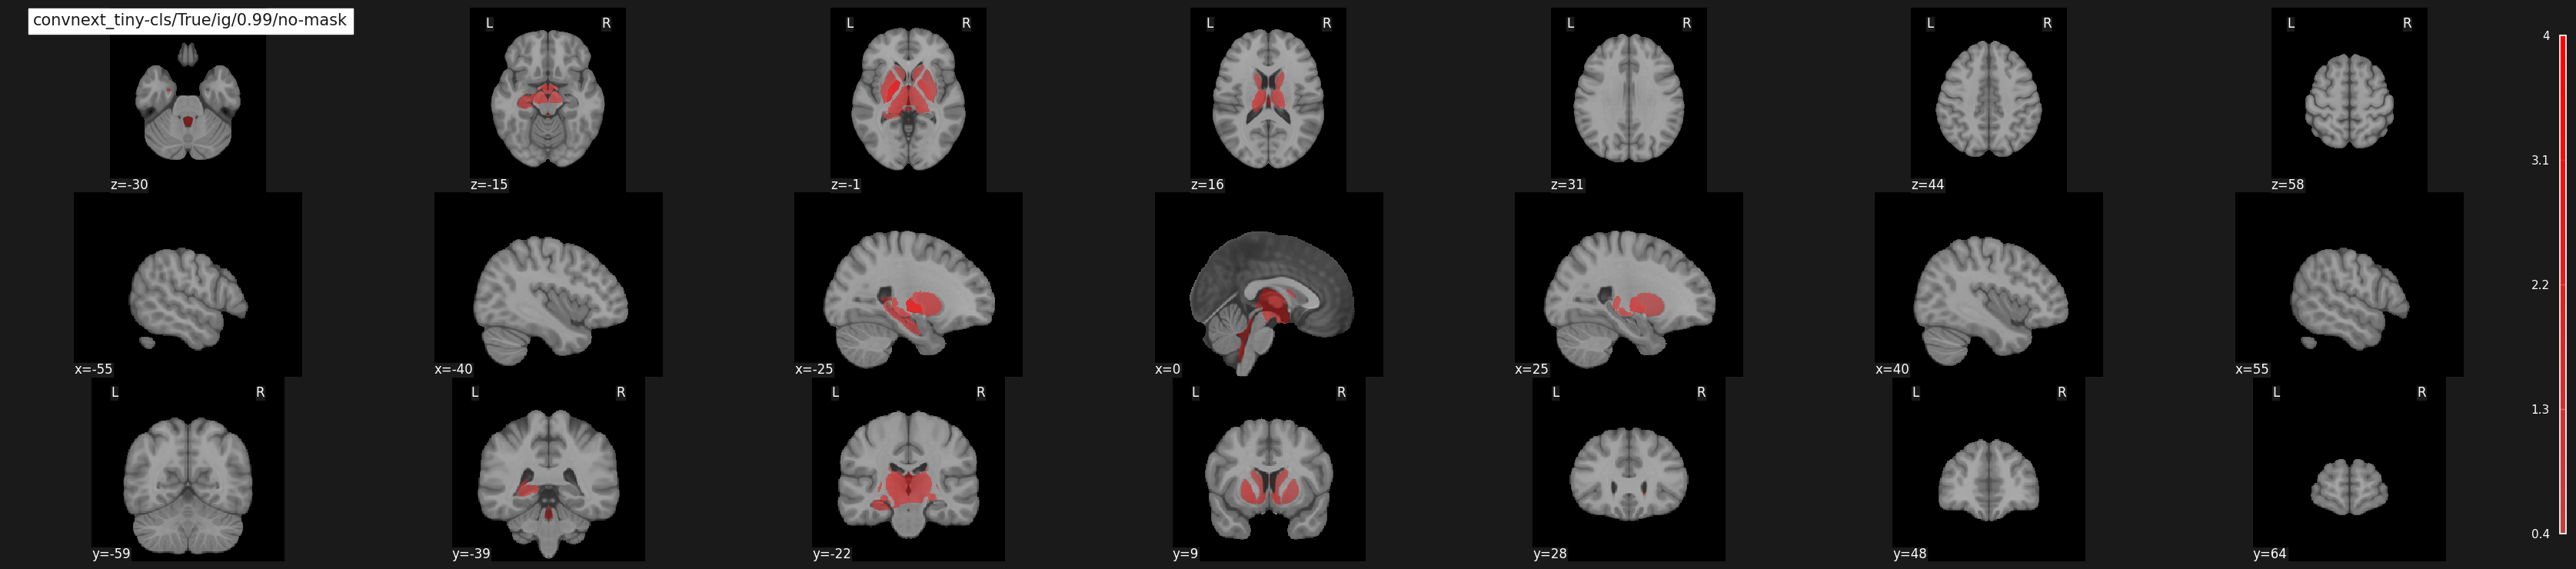

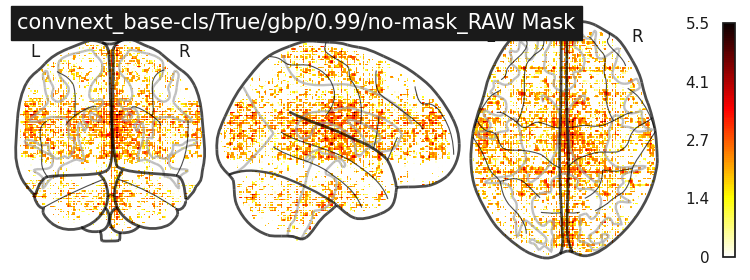

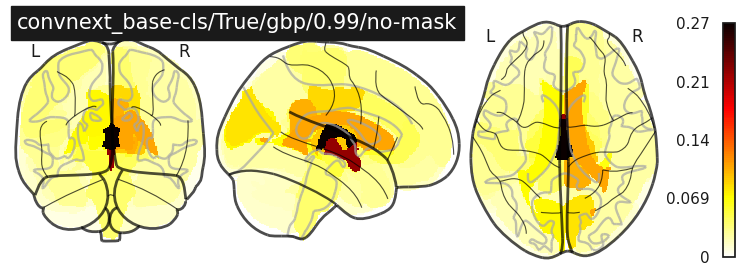

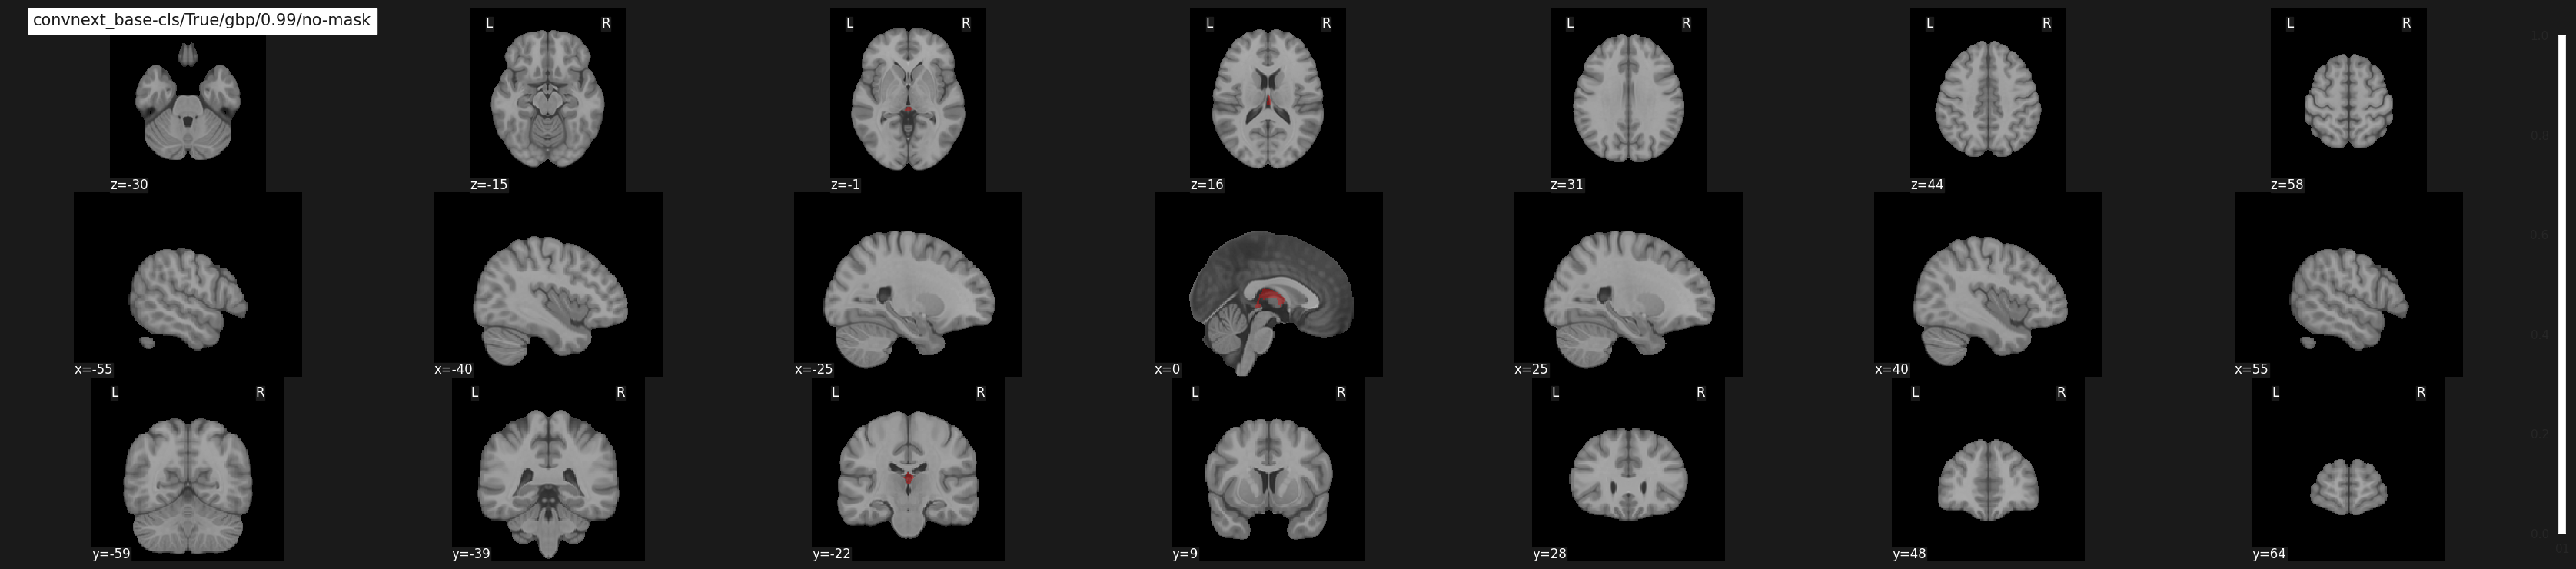

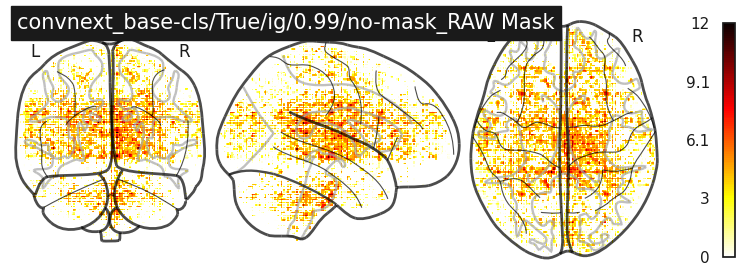

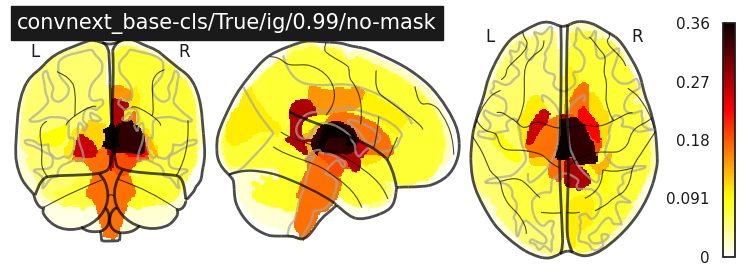

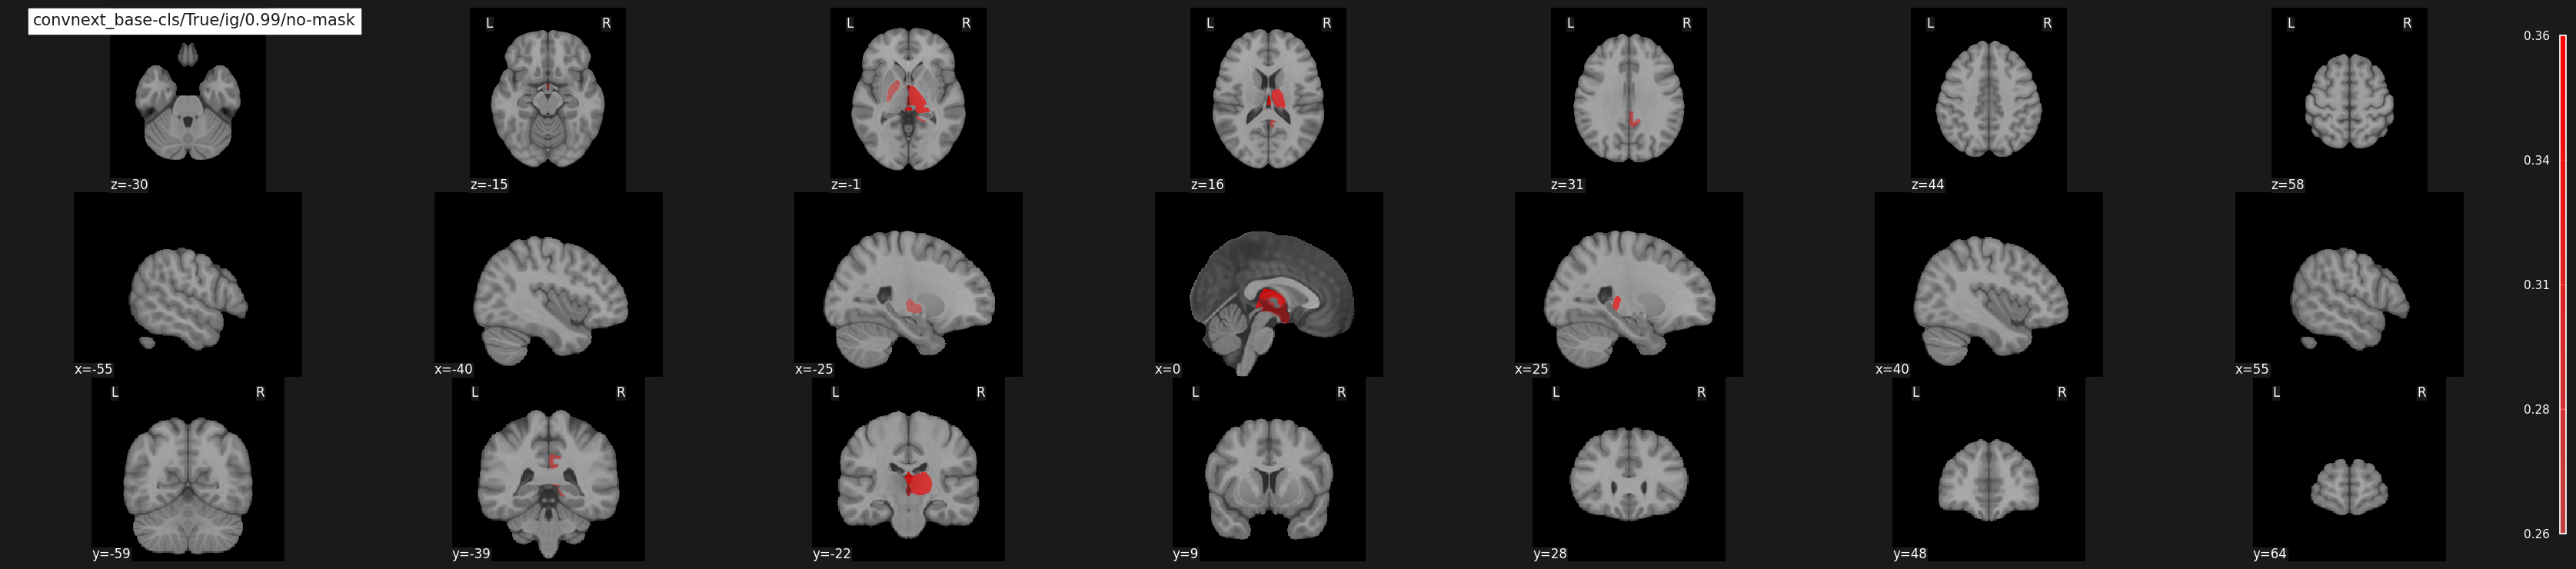

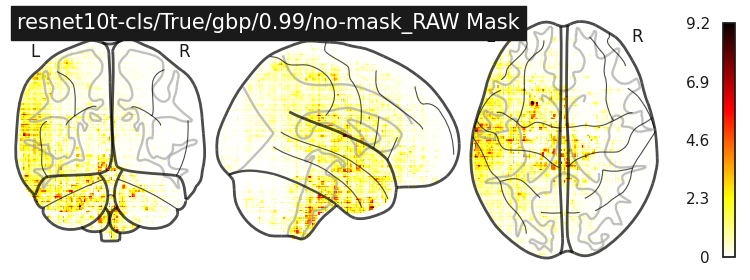

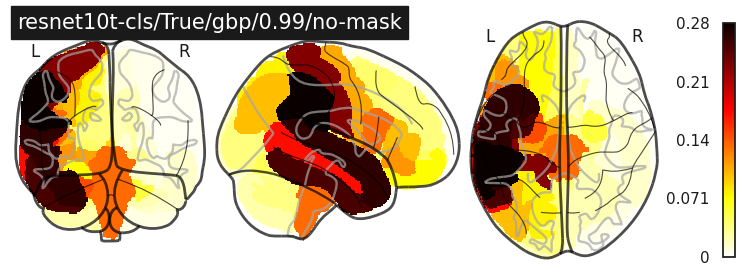

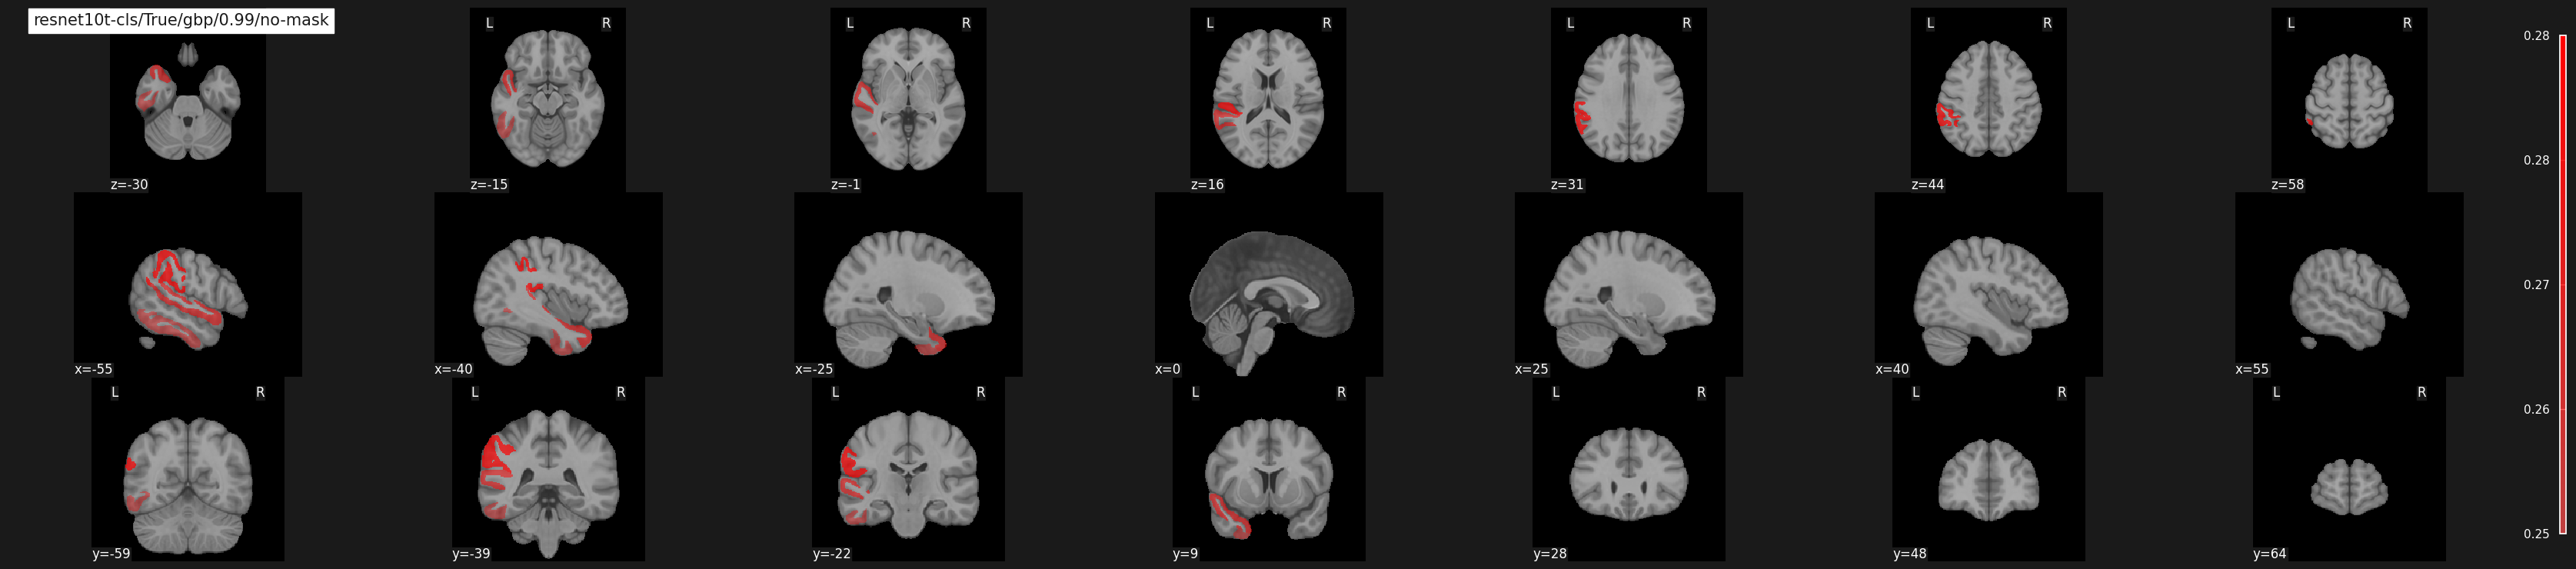

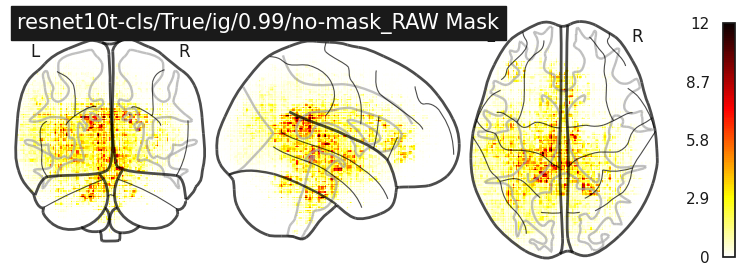

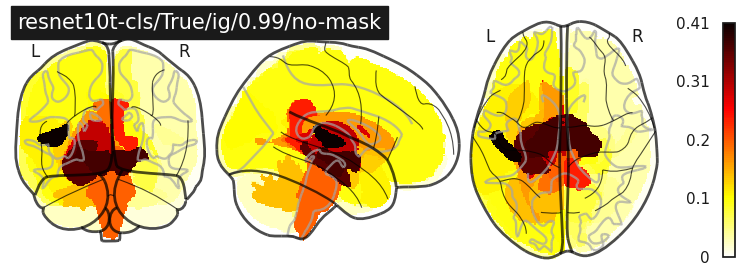

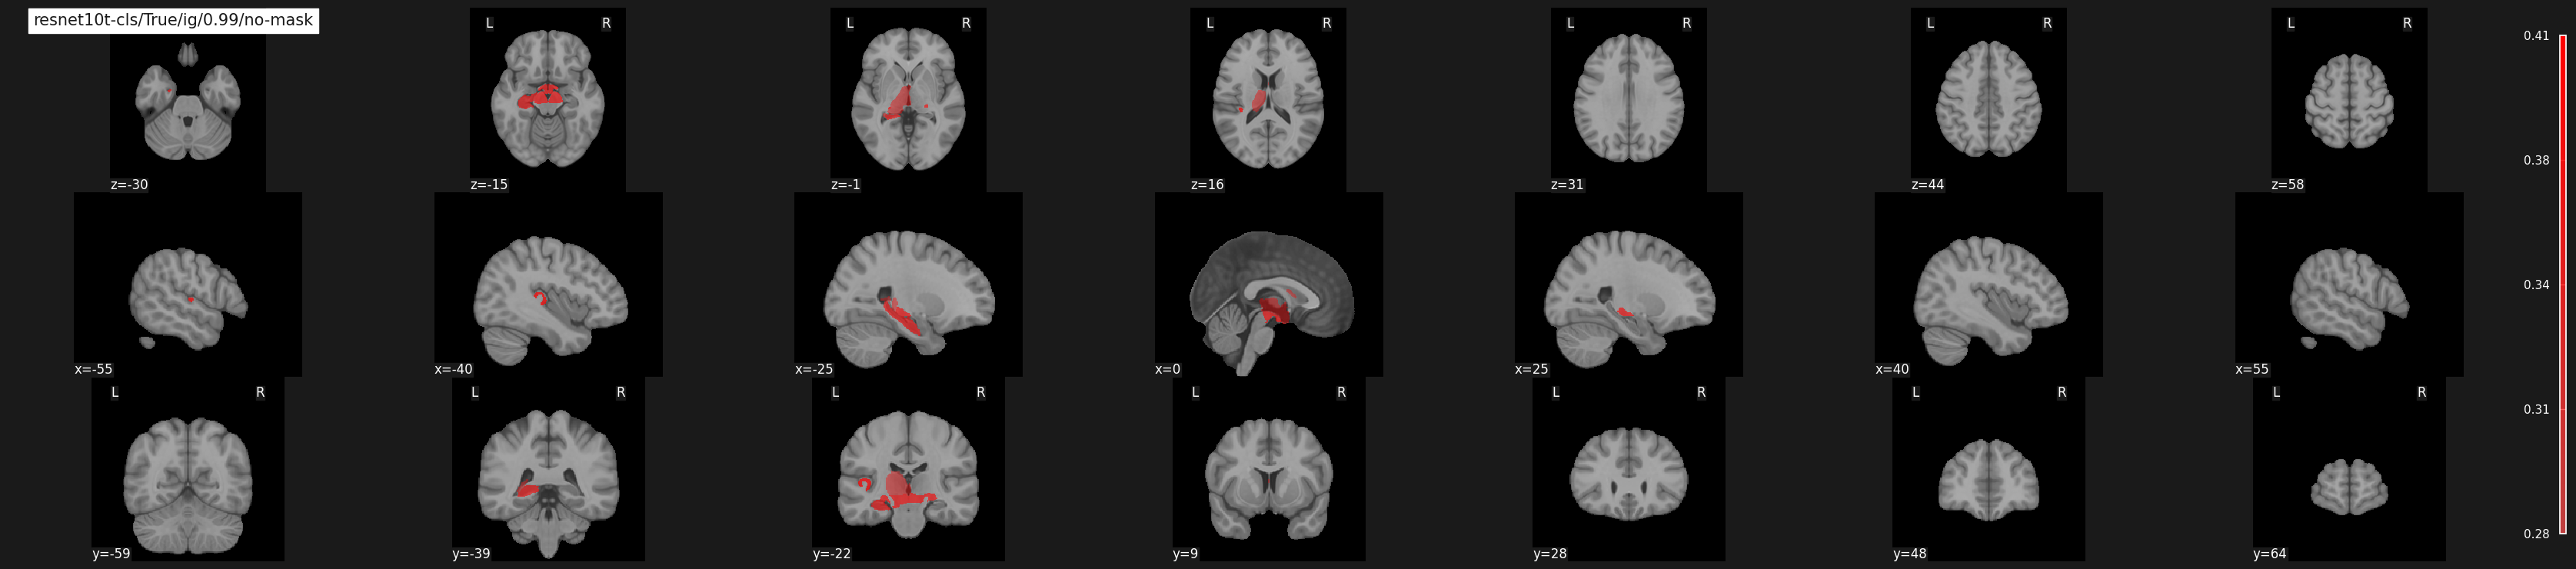

In [3]:
use_abs = True
for model in ["convnext_tiny-cls", "convnext_base-cls", "resnet10t-cls"]:
    for xai in ["gbp", "ig"]:
        sal_dict = dict(load_top=True, xai=xai, top_k=0.99, mask="no-mask")
        config = dict(path=model, **sal_dict)
        sal, sal_path = ao.load_sal(**config)
        sal = ao.resample_sal(arr=sal, atlas=atlas.nii)
        
        title = "/".join([str(c) for c in config.values()])
        xai_dict, agg_saliency = ao.calculate_overlaps(arr=sal,
                                                       atlas=atlas,
                                                       title=title,
                                                       use_abs=use_abs,
                                                       plot_projection=True,
                                                       plot_bargraph=False);
        with (sal_path.parent / "xai_dict.json").open(mode="w") as f:
            json.dump(obj=xai_dict, fp=f, indent="\t")

In [14]:
vox_df, int_df = defaultdict(dict), defaultdict(dict)
cont12_df, cont21_df = defaultdict(dict), defaultdict(dict)
for model in ["convnext_tiny-cls", "convnext_base-cls", "resnet10t-cls"]:
    for xai in ["gbp", "ig"]:
        sal_dict = dict(load_top=True, xai=xai, top_k=0.99, mask="no-mask")
        config = dict(path=model, **sal_dict)
        _, sal_path = ao.load_sal(**config)
        xai_dict = sal_path.parent / "xai_dict.json"
        with xai_dict.open(mode="r") as f:
            xai_dict = json.load(f)
        print(model, xai)
        _stats = sort_xai_dict(dct=xai_dict)
        
        print("*** VOLUME ***")
        result = run_stats(a=vox_spear, b=_stats)
        vox_df["stats"][f"{model}_{xai}"] = result["stats"]
        vox_df["pval"][f"{model}_{xai}"] = result["pval"]
        
        print("*** INTENSITY ***")
        result = run_stats(a=int_spear, b=_stats)
        int_df["stats"][f"{model}_{xai}"] = result["stats"]
        int_df["pval"][f"{model}_{xai}"] = result["pval"]
        
        print("*** Old to Young Contrast ***")
        result = run_stats(a=_cont_12_dict, b=_stats)
        cont12_df["stats"][f"{model}_{xai}"] = result["stats"]
        cont12_df["pval"][f"{model}_{xai}"] = result["pval"]
        
        print("*** Young to Old Contrast ***")
        result = run_stats(a=_cont_21_dict, b=_stats)
        cont21_df["stats"][f"{model}_{xai}"] = result["stats"]
        cont21_df["pval"][f"{model}_{xai}"] = result["pval"]
        print()

convnext_tiny-cls gbp
*** VOLUME ***
wilcoxon: STAT 326.0000 | p-val: 0.0000
spearmanr: STAT 0.1468 | p-val: 0.1559
kendalltau: STAT 0.0988 | p-val: 0.1562
somersd: STAT 0.0988 | p-val: 0.2575
kruskal: STAT 85.3023 | p-val: 0.0000
*** INTENSITY ***
wilcoxon: STAT 1875.0000 | p-val: 0.1328
spearmanr: STAT -0.3347 | p-val: 0.0009
kendalltau: STAT -0.2148 | p-val: 0.0020
somersd: STAT -0.2148 | p-val: 0.0032
kruskal: STAT 10.2176 | p-val: 0.0014
*** Old to Young Contrast ***
wilcoxon: STAT 1545.0000 | p-val: 0.0064
spearmanr: STAT 0.4184 | p-val: 0.0000
kendalltau: STAT 0.2936 | p-val: 0.0000
somersd: STAT 0.2936 | p-val: 0.0000
kruskal: STAT 33.7088 | p-val: 0.0000
*** Young to Old Contrast ***
wilcoxon: STAT 997.0000 | p-val: 0.0000
spearmanr: STAT 0.1312 | p-val: 0.2049
kendalltau: STAT 0.0898 | p-val: 0.1973
somersd: STAT 0.0898 | p-val: 0.1753
kruskal: STAT 53.9365 | p-val: 0.0000

convnext_tiny-cls ig
*** VOLUME ***
wilcoxon: STAT 408.0000 | p-val: 0.0000
spearmanr: STAT 0.1430 | p-

# FastSurfer: Voxel Result

In [19]:
pd.DataFrame(vox_df["stats"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon               326.000000            408.000000  \
spearmanr                0.146753              0.143043   
kendalltau               0.098768              0.105487   
somersd                  0.098768              0.105487   
kruskal                 85.302318             85.399820   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon               699.000000            618.000000         777.000000  \
spearmanr                0.421948              0.295395          -0.086842   
kendalltau               0.295409              0.218813          -0.056663   
somersd                  0.295409              0.218813          -0.056663   
kruskal                 78.849666             80.782531          77.822168   

            resnet10t-cls_ig  
wilcoxon          529.000000  
spearmanr           0.090202  
kendalltau          0.062038  
somersd             0.062038  
kruskal            81.972593

In [20]:
pd.DataFrame(vox_df["pval"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon             4.077205e-13          3.689268e-12  \
spearmanr            1.558620e-01          1.667024e-01   
kendalltau           1.562331e-01          1.299478e-01   
somersd              2.574680e-01          2.147749e-01   
kruskal              2.560629e-20          2.437428e-20   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon             4.398888e-09          6.867530e-10       2.420100e-08  \
spearmanr            2.054813e-05          3.658647e-03       4.026997e-01   
kendalltau           2.228193e-05          1.682895e-03       4.159785e-01   
somersd              3.459975e-05          4.625449e-03       3.575597e-01   
kruskal              6.702077e-19          2.519757e-19       1.127477e-18   

            resnet10t-cls_ig  
wilcoxon        8.060571e-11  
spearmanr       3.846769e-01  
kendalltau      3.731545e-01  
somersd         4.008876e-01  
kruskal         1.379869e-19

In [32]:
pd.DataFrame(vox_df["pval"]).applymap(func=lambda p: "significant" if p < 0.05 else "")

convnext_tiny-cls_gbp convnext_tiny-cls_ig convnext_base-cls_gbp   
wilcoxon             significant          significant           significant  \
spearmanr                                                       significant   
kendalltau                                                      significant   
somersd                                                         significant   
kruskal              significant          significant           significant   

           convnext_base-cls_ig resnet10t-cls_gbp resnet10t-cls_ig  
wilcoxon            significant       significant      significant  
spearmanr           significant                                     
kendalltau          significant                                     
somersd             significant                                     
kruskal             significant       significant      significant

# FastSurfer: Intensity Result

In [22]:
pd.DataFrame(int_df["stats"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon              1875.000000           1928.000000  \
spearmanr               -0.334728             -0.293911   
kendalltau              -0.214782             -0.174916   
somersd                 -0.214782             -0.174916   
kruskal                 10.217567              9.407768   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon              1207.000000           1387.000000        1227.000000  \
spearmanr               -0.251904             -0.335148          -0.185274   
kendalltau              -0.170437             -0.229115          -0.117581   
somersd                 -0.170437             -0.229115          -0.117581   
kruskal                 41.905670             30.656221          36.650237   

            resnet10t-cls_ig  
wilcoxon         1488.000000  
spearmanr          -0.457293  
kendalltau         -0.324076  
somersd            -0.324076  
kruskal            23.709848

In [23]:
pd.DataFrame(int_df["pval"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon                 0.132761              0.191357  \
spearmanr                0.000915              0.003841   
kendalltau               0.002047              0.012039   
somersd                  0.003178              0.018091   
kruskal                  0.001391              0.002161   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon             6.810086e-05          9.174466e-04       9.283715e-05  \
spearmanr            1.379334e-02          9.003538e-04       7.225282e-02   
kendalltau           1.441772e-02          1.005306e-03       9.142609e-02   
somersd              2.124463e-02          1.584215e-03       6.763504e-02   
kruskal              9.578446e-11          3.080374e-08       1.413418e-09   

            resnet10t-cls_ig  
wilcoxon        3.284320e-03  
spearmanr       3.181999e-06  
kendalltau      3.283548e-06  
somersd         2.277453e-07  
kruskal         1.120079e-06

In [31]:
pd.DataFrame(int_df["pval"]).applymap(func=lambda p: "significant" if p < 0.05 else "")

convnext_tiny-cls_gbp convnext_tiny-cls_ig convnext_base-cls_gbp   
wilcoxon                                                        significant  \
spearmanr            significant          significant           significant   
kendalltau           significant          significant           significant   
somersd              significant          significant           significant   
kruskal              significant          significant           significant   

           convnext_base-cls_ig resnet10t-cls_gbp resnet10t-cls_ig  
wilcoxon            significant       significant      significant  
spearmanr           significant                        significant  
kendalltau          significant                        significant  
somersd             significant                        significant  
kruskal             significant       significant      significant

# VBM: Old-to-Young

In [25]:
pd.DataFrame(cont12_df["stats"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon              1545.000000           1802.000000  \
spearmanr                0.418407              0.476764   
kendalltau               0.293617              0.346920   
somersd                  0.293617              0.346920   
kruskal                 33.708809              0.697346   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon              1616.000000           1576.000000        1789.000000  \
spearmanr                0.466251              0.427604          -0.270997   
kendalltau               0.299440              0.293617          -0.183427   
somersd                  0.299440              0.293617          -0.183427   
kruskal                 39.981173             38.920580          32.404273   

            resnet10t-cls_ig  
wilcoxon         1522.000000  
spearmanr           0.150098  
kendalltau          0.098320  
somersd             0.098320  
kruskal            42.729518

In [26]:
pd.DataFrame(cont12_df["pval"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon             6.367777e-03          7.601870e-02  \
spearmanr            2.449412e-05          1.038172e-06   
kendalltau           2.497961e-05          6.352668e-07   
somersd              2.278210e-05          8.909942e-07   
kruskal              6.401015e-09          4.036770e-01   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon             1.371377e-02          8.971218e-03       6.837567e-02  \
spearmanr            1.916931e-06          1.545833e-05       7.900736e-03   
kendalltau           1.718988e-05          2.497961e-05       8.459468e-03   
somersd              3.081434e-09          9.632606e-07       1.166705e-03   
kruskal              2.564224e-10          4.414025e-10       1.252109e-08   

            resnet10t-cls_ig  
wilcoxon        4.899176e-03  
spearmanr       1.465445e-01  
kendalltau      1.581194e-01  
somersd         1.091831e-01  
kruskal         6.285659e-11

In [33]:
pd.DataFrame(cont12_df["pval"]).applymap(func=lambda p: "significant" if p < 0.05 else "")

convnext_tiny-cls_gbp convnext_tiny-cls_ig convnext_base-cls_gbp   
wilcoxon             significant                                significant  \
spearmanr            significant          significant           significant   
kendalltau           significant          significant           significant   
somersd              significant          significant           significant   
kruskal              significant                                significant   

           convnext_base-cls_ig resnet10t-cls_gbp resnet10t-cls_ig  
wilcoxon            significant                        significant  
spearmanr           significant       significant                   
kendalltau          significant       significant                   
somersd             significant       significant                   
kruskal             significant       significant      significant

# VBM: Young-to-Old

In [27]:
pd.DataFrame(cont21_df["stats"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon               997.000000           1419.000000  \
spearmanr                0.131229              0.202842   
kendalltau               0.089810              0.135946   
somersd                  0.089810              0.135946   
kruskal                 53.936545              4.813103   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon              1162.000000            976.000000        1261.000000  \
spearmanr                0.369485              0.327184          -0.197102   
kendalltau               0.227324              0.206271          -0.129227   
somersd                  0.227324              0.206271          -0.129227   
kruskal                 63.386274             60.972971          51.978173   

            resnet10t-cls_ig  
wilcoxon          921.000000  
spearmanr           0.142343  
kendalltau          0.095185  
somersd             0.095185  
kruskal            65.718017

In [28]:
pd.DataFrame(cont21_df["pval"])

convnext_tiny-cls_gbp  convnext_tiny-cls_ig   
wilcoxon             1.913840e-06              0.001394  \
spearmanr            2.049339e-01              0.048675   
kendalltau           1.973107e-01              0.050990   
somersd              1.752706e-01              0.029744   
kruskal              2.070702e-13              0.028244   

            convnext_base-cls_gbp  convnext_base-cls_ig  resnet10t-cls_gbp   
wilcoxon             3.326804e-05          1.296663e-06       1.553330e-04  \
spearmanr            2.287828e-04          1.210740e-03       5.555488e-02   
kendalltau           1.101163e-03          3.065439e-03       6.358091e-02   
somersd              4.955309e-05          9.291735e-04       4.243264e-02   
kruskal              1.698977e-15          5.786381e-15       5.612103e-13   

            resnet10t-cls_ig  
wilcoxon        4.549064e-07  
spearmanr       1.688088e-01  
kendalltau      1.718092e-01  
somersd         1.570561e-01  
kruskal         5.202806e-16

In [34]:
pd.DataFrame(cont21_df["pval"]).applymap(func=lambda p: "significant" if p < 0.05 else "")

convnext_tiny-cls_gbp convnext_tiny-cls_ig convnext_base-cls_gbp   
wilcoxon             significant          significant           significant  \
spearmanr                                 significant           significant   
kendalltau                                                      significant   
somersd                                   significant           significant   
kruskal              significant          significant           significant   

           convnext_base-cls_ig resnet10t-cls_gbp resnet10t-cls_ig  
wilcoxon            significant       significant      significant  
spearmanr           significant                                     
kendalltau          significant                                     
somersd             significant       significant                   
kruskal             significant       significant      significant